In [1]:
# 필요한 라이브러리 설치
!pip install datasets torch torchvision scikit-learn matplotlib
!git clone https://github.com/HRNet/HRNet-Image-Classification
%cd HRNet-Image-Classification
!pip install -r requirements.txt
%cd ..

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from datasets import load_dataset
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# HRNet 모델 임포트 (리포지토리 구조에 따라 경로 조정 필요)
import sys
sys.path.append('HRNet-Image-Classification/lib')
from models.cls_hrnet import get_cls_net

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# 데이터셋 로드
dataset = load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation")
train = dataset["train"]
test = dataset["test"]
valid = dataset["valid"]

# 이미지 전처리 파이프라인
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 커스텀 데이터셋 클래스
class BrainTumorDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        label = self.dataset[idx]["category_id"]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)
# 데이터로더 생성
train_dataset = BrainTumorDataset(train, transform=transform)
valid_dataset = BrainTumorDataset(valid, transform=transform)
test_dataset = BrainTumorDataset(test, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# HRNet 모델 초기화 및 수정
hrnet_config = {
    'MODEL': {
        'EXTRA': {
            'STAGE1': {
                'NUM_MODULES': 1,
                'NUM_BRANCHES': 1,
                'BLOCK': 'BOTTLENECK',
                'NUM_BLOCKS': [4],
                'NUM_CHANNELS': [64],
                'FUSE_METHOD': 'SUM'
            },
            'STAGE2': {
                'NUM_MODULES': 1,
                'NUM_BRANCHES': 2,
                'BLOCK': 'BASIC',
                'NUM_BLOCKS': [4,4],
                'NUM_CHANNELS': [48, 96],
                'FUSE_METHOD': 'SUM'
            },
            'STAGE3': {
                'NUM_MODULES': 4,
                'NUM_BRANCHES': 3,
                'BLOCK': 'BASIC',
                'NUM_BLOCKS': [4,4,4],
                'NUM_CHANNELS': [48, 96, 192],
                'FUSE_METHOD': 'SUM'
            },
            'STAGE4': {
                'NUM_MODULES': 3,
                'NUM_BRANCHES': 4,
                'BLOCK': 'BASIC',
                'NUM_BLOCKS': [4,4,4,4],
                'NUM_CHANNELS': [48, 96, 192, 384],
                'FUSE_METHOD': 'SUM'
            }
        },
        'PRETRAINED': '',
        'NUM_CLASSES': 1000
    }
}

# 수정된 모델 초기화
model = get_cls_net(hrnet_config)
model.classifier = nn.Linear(model.classifier.in_features, 1)

README.md:   0%|          | 0.00/6.22k [00:00<?, ?B/s]

(…)-00000-of-00001-1d7ef230dfbdad78.parquet:   0%|          | 0.00/113M [00:00<?, ?B/s]

(…)-00000-of-00001-0031debf8df4462b.parquet:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

(…)-00000-of-00001-bce5cef16a5cce11.parquet:   0%|          | 0.00/32.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1502 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/215 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/429 [00:00<?, ? examples/s]

Epoch 1/20
Train Loss: -18.3667 | Val F1: 0.6573 | Val Recall: 1.0000
Val Precision: 0.4895 | Val IoU: 0.0000 | Val AUC: 0.5000
Epoch 2/20
Train Loss: -74.6803 | Val F1: 0.6573 | Val Recall: 1.0000
Val Precision: 0.4895 | Val IoU: 0.0000 | Val AUC: 0.5000
Epoch 3/20
Train Loss: -144.8441 | Val F1: 0.6573 | Val Recall: 1.0000
Val Precision: 0.4895 | Val IoU: 0.0000 | Val AUC: 0.9233
Epoch 4/20
Train Loss: -237.3916 | Val F1: 0.6573 | Val Recall: 1.0000
Val Precision: 0.4895 | Val IoU: 0.0000 | Val AUC: 0.8975
Epoch 5/20
Train Loss: -345.0891 | Val F1: 0.6573 | Val Recall: 1.0000
Val Precision: 0.4895 | Val IoU: 0.0000 | Val AUC: 0.9259
Epoch 6/20
Train Loss: -472.5163 | Val F1: 0.6573 | Val Recall: 1.0000
Val Precision: 0.4895 | Val IoU: 0.0000 | Val AUC: 0.6167
Epoch 7/20
Train Loss: -615.5448 | Val F1: 0.6573 | Val Recall: 1.0000
Val Precision: 0.4895 | Val IoU: 0.0000 | Val AUC: 0.8679
Epoch 8/20
Train Loss: -785.4235 | Val F1: 0.6573 | Val Recall: 1.0000
Val Precision: 0.4895 | Val 

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from fon

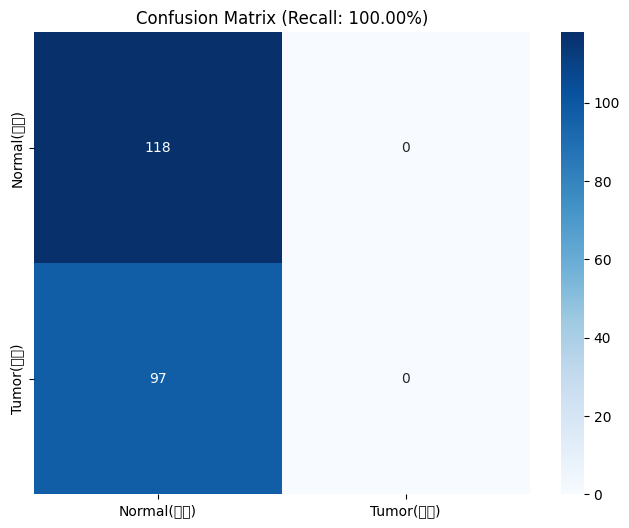

In [3]:
from sklearn.metrics import recall_score, precision_score
# 학습 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 20
best_val_auc = 0

for epoch in range(num_epochs):
    # 학습 단계
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

   # 검증 단계 - recall 추가
    model.eval()
    val_probs, val_labels = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            val_probs.extend(torch.sigmoid(outputs).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_preds = (np.array(val_probs) > 0.5).astype(int)
    val_f1 = f1_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)  # 추가된 recall 계산
    val_precision = precision_score(val_labels, val_preds)  # 추가된 precision
    tn, fp, fn, tp = confusion_matrix(val_labels, val_preds).ravel()
    val_iou = tp / (tp + fp + fn)
    val_auc = roc_auc_score(val_labels, val_probs)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val F1: {val_f1:.4f} | Val Recall: {val_recall:.4f}")
    print(f"Val Precision: {val_precision:.4f} | Val IoU: {val_iou:.4f} | Val AUC: {val_auc:.4f}")


    # 최고 모델 저장
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pth')

# 테스트 평가 수정 (recall 추가)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_probs, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        test_probs.extend(torch.sigmoid(outputs).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds = (np.array(test_probs) > 0.5).astype(int)
test_f1 = f1_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)  # 추가된 recall
test_precision = precision_score(test_labels, test_preds)  # 추가된 precision
tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()
test_iou = tp / (tp + fp + fn)
test_auc = roc_auc_score(test_labels, test_probs)

# 최종 결과 출력 수정
print("\n=== 최종 테스트 성능 ===")
print(f"F1-score: {test_f1:.4f}")
print(f"Recall (민감도): {test_recall:.4f}  [진양성률: {tp}/{tp+fn}]")
print(f"Precision (정밀도): {test_precision:.4f}  [진양성/예측양성: {tp}/{tp+fp}]")
print(f"IoU: {test_iou:.4f}")
print(f"ROC-AUC: {test_auc:.4f}")

# 혼동 행렬 시각화 추가
import seaborn as sns
conf_mat = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal(예측)','Tumor(예측)'],
            yticklabels=['Normal(실제)','Tumor(실제)'])
plt.title('Confusion Matrix (Recall: {:.2f}%)'.format(test_recall*100))
plt.show()

"""
model : HRNet-W18-C
num_epochs = 20
=== 최종 테스트 성능 ===
F1-score: 0.7087
Recall (민감도): 1.0000  [진양성률: 0/97]
Precision (정밀도): 0.5488  [진양성/예측양성: 0/0]
IoU: 0.0000
ROC-AUC: 0.9206

"""